In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta


In [22]:
tx_data=pd.read_csv('OnlineRetail.csv',encoding="latin1")
tx_data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


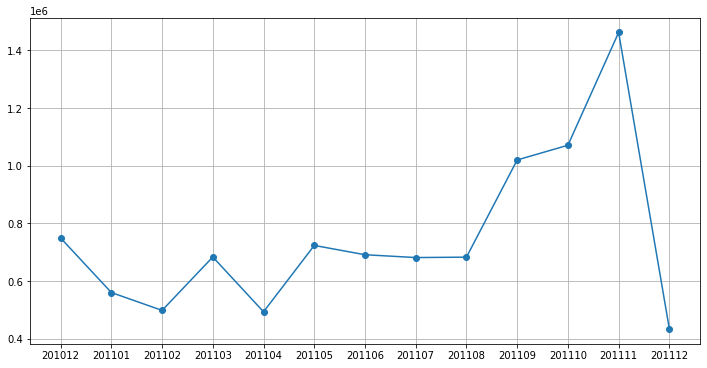

In [25]:
tx_data['InvoiceDate']=pd.to_datetime(tx_data['InvoiceDate'])
tx_data['InvoiceYearMonth']=tx_data['InvoiceDate'].map(lambda date:100*date.year+date.month)
tx_data['Revenue']=tx_data['UnitPrice']*tx_data['Quantity']
tx_revenue=tx_data.groupby(['InvoiceYearMonth'])['Revenue'].sum().reset_index()
plt.figure(figsize=(12,6))
plt.plot(tx_revenue['InvoiceYearMonth'].to_numpy(dtype='str'),tx_revenue['Revenue'],marker='o')
plt.grid()

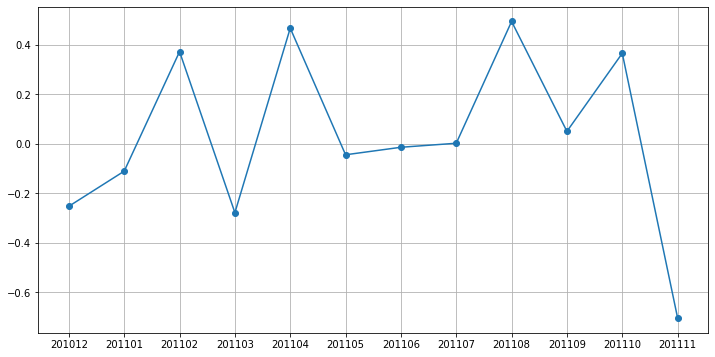

In [38]:
tx_revenue['MonthlyGrowth']=tx_revenue['Revenue'].pct_change()
plt.figure(figsize=(12,6))
plt.plot(tx_revenue.query("InvoiceYearMonth < 201112")['InvoiceYearMonth'].to_numpy(dtype='str'), tx_revenue.query("MonthlyGrowth < 201112")['MonthlyGrowth'], marker='o')
plt.grid()

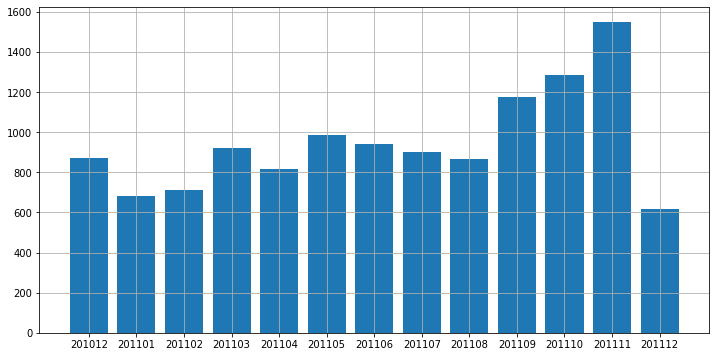

In [46]:
tx_uk=tx_data.query("Country=='United Kingdom'").reset_index(drop=True)
tx_monthly_active=tx_uk.groupby('InvoiceYearMonth')['CustomerID'].nunique().reset_index()
plt.figure(figsize=(12,6))
plt.bar(tx_monthly_active['InvoiceYearMonth'].to_numpy(dtype='str'),tx_monthly_active['CustomerID'])
plt.grid()

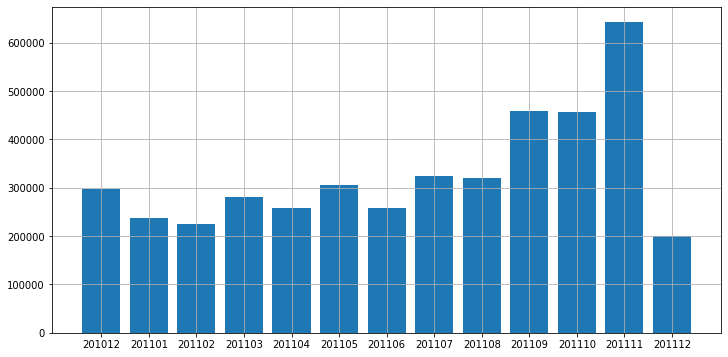

In [50]:
tx_monthly_seles=tx_uk.groupby('InvoiceYearMonth')['Quantity'].sum().reset_index()
plt.figure(figsize=(12,6))
plt.bar(tx_monthly_sales['InvoiceYearMonth'].to_numpy(dtype='str'),tx_monthly_sales['Quantity'])
plt.grid()

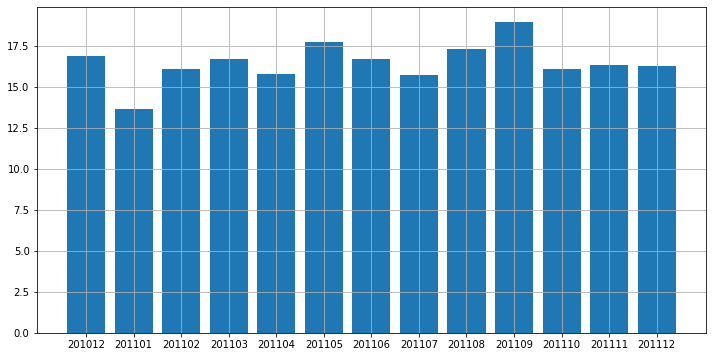

In [51]:
tx_monthly_order_avg = tx_uk.groupby('InvoiceYearMonth')['Revenue'].mean().reset_index()
plt.figure(figsize=(12,6))
plt.bar(tx_monthly_order_avg['InvoiceYearMonth'].to_numpy(dtype='str'), tx_monthly_order_avg['Revenue'])
plt.grid()

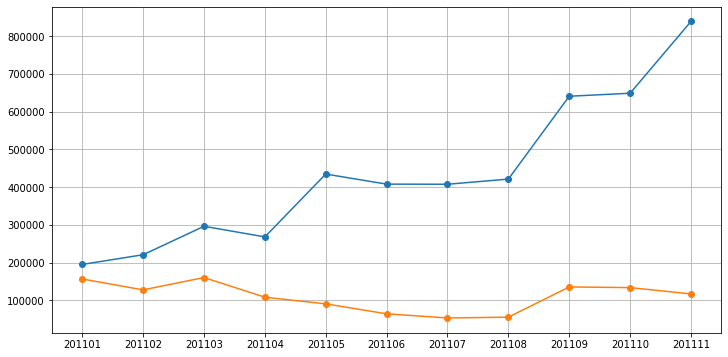

In [52]:
tx_min_purchase = tx_uk.groupby('CustomerID').InvoiceDate.min().reset_index()
tx_min_purchase.columns = ['CustomerID','MinPurchaseDate']
tx_min_purchase['MinPurchaseYearMonth'] = tx_min_purchase['MinPurchaseDate'].map(lambda date: 100*date.year + date.month)

tx_uk = pd.merge(tx_uk, tx_min_purchase, on='CustomerID')

tx_uk.head()

tx_uk['UserType'] = 'New'
tx_uk.loc[tx_uk['InvoiceYearMonth']>tx_uk['MinPurchaseYearMonth'],'UserType'] = 'Existing'

tx_user_type_revenue = tx_uk.groupby(['InvoiceYearMonth','UserType'])['Revenue'].sum().reset_index()

tx_user_type_revenue = tx_user_type_revenue.query("InvoiceYearMonth != 201012 and InvoiceYearMonth != 201112")
tx_monthly_order_avg = tx_uk.groupby('InvoiceYearMonth')['Revenue'].mean().reset_index()


plt.figure(figsize=(12,6))
plt.plot(tx_user_type_revenue.query("UserType == 'Existing'")['InvoiceYearMonth'].to_numpy(dtype='str'), tx_user_type_revenue.query("UserType == 'Existing'")['Revenue'], marker='o')
plt.plot(tx_user_type_revenue.query("UserType == 'New'")['InvoiceYearMonth'].to_numpy(dtype='str'), tx_user_type_revenue.query("UserType == 'New'")['Revenue'], marker='o')

plt.grid()



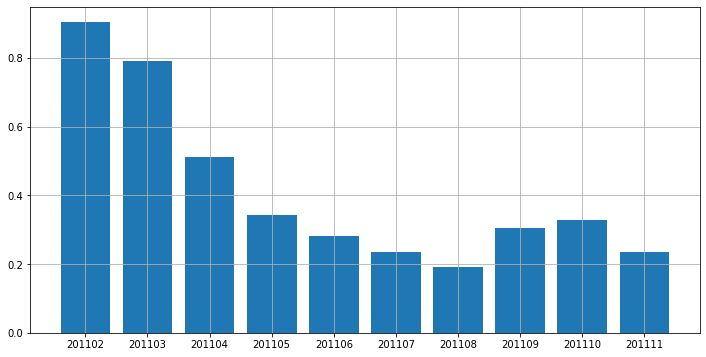

In [53]:
tx_user_ratio = tx_uk.query("UserType == 'New'").groupby(['InvoiceYearMonth'])['CustomerID'].nunique()/tx_uk.query("UserType == 'Existing'").groupby(['InvoiceYearMonth'])['CustomerID'].nunique() 
tx_user_ratio = tx_user_ratio.reset_index()
tx_user_ratio = tx_user_ratio.dropna()

plt.figure(figsize=(12,6))
plt.bar(tx_user_ratio.query("InvoiceYearMonth>201101 and InvoiceYearMonth<201112")['InvoiceYearMonth'].to_numpy(dtype='str'), tx_user_ratio.query("InvoiceYearMonth>201101 and InvoiceYearMonth<201112")['CustomerID'])

plt.grid()



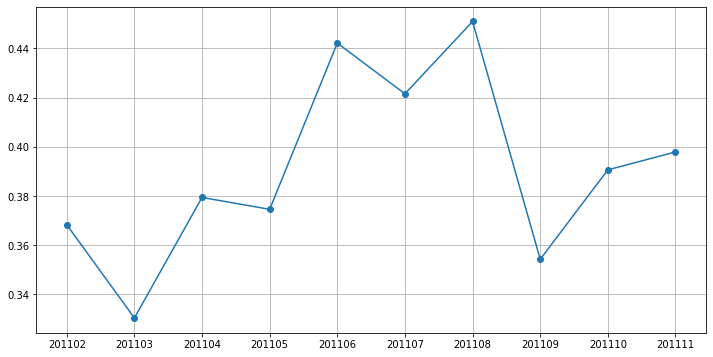

In [54]:
tx_user_purchase = tx_uk.groupby(['CustomerID','InvoiceYearMonth'])['Revenue'].sum().reset_index()

tx_retention = pd.crosstab(tx_user_purchase['CustomerID'], tx_user_purchase['InvoiceYearMonth']).reset_index()

tx_retention.head()

months = tx_retention.columns[2:]
retention_array = []
for i in range(len(months)-1):
    retention_data = {}
    selected_month = months[i+1]
    prev_month = months[i]
    retention_data['InvoiceYearMonth'] = int(selected_month)
    retention_data['TotalUserCount'] = tx_retention[selected_month].sum()
    retention_data['RetainedUserCount'] = tx_retention[(tx_retention[selected_month]>0) & (tx_retention[prev_month]>0)][selected_month].sum()
    retention_array.append(retention_data)
    
tx_retention = pd.DataFrame(retention_array)
tx_retention['RetentionRate'] = tx_retention['RetainedUserCount']/tx_retention['TotalUserCount']

plt.figure(figsize=(12,6))
plt.plot(tx_retention.query("InvoiceYearMonth<201112")['InvoiceYearMonth'].to_numpy(dtype='str'), tx_retention.query("InvoiceYearMonth<201112")['RetentionRate'], marker='o')

plt.grid()